# Dependencies and files

## Install dependencies

## Imports

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
de_dir_path = '../../data/DE/ANOVA_zscore/'

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
os.listdir(de_dir_path)

['anova_mamm_zscore.csv',
 'cluster_spectr_anova_zscore_6.csv',
 'cluster_spectr_anova_zscore_7.csv',
 'cluster_spectr_anova_zscore_8.csv',
 'cluster_spectr_anova_zscore_9.csv',
 'ttest_human_monkey_zscore.csv',
 'ttest_mamm_zscore.csv']

### DE results

In [5]:
anova_res = pd.read_csv(de_dir_path + 'anova_mamm_zscore.csv', index_col=0)
anova_genes = anova_res[anova_res.p_val_adj < 0.05].index
anova_res.head()

,sum_sq,df,F,PR(>F),p_val_adj
A1BG,16.406416,12.0,2.634814,0.005952,0.024619
AAAS,11.650260,12.0,1.203083,0.299204,0.420750
AACS,7.838514,12.0,1.515760,0.140030,0.245693
AADAT,11.017066,12.0,1.720198,0.081496,0.166637
AAGAB,13.101968,12.0,1.491386,0.149069,0.256374


In [6]:
ttest_res = pd.read_csv(de_dir_path + 'ttest_mamm_zscore.csv', index_col=0)
ttest_res.head()

,gene,layer,group1,group2,score,pvalue,p_val_adj
0,A1BG,L1,human,chimp,-2.069551,0.083940,0.280856
1,AARS1,L1,human,chimp,-0.106135,0.918935,0.963909
2,AATK,L1,human,chimp,-0.913974,0.395973,0.625443
3,ABAT,L1,human,chimp,0.435186,0.678645,0.828286
4,ABCA2,L1,human,chimp,-0.600076,0.570409,0.752111


In [7]:
n_clusters = 7
anova_labels = pd.read_csv(de_dir_path + f'cluster_spectr_anova_zscore_{n_clusters}.csv', index_col=0)['0'].sort_values()
anova_labels = anova_labels + 1
anova_labels.name = 'ANOVA_labels'

In [8]:
hum_spec_onehot = pd.read_csv('results/hum_spec_onehot.csv', index_col=0)
hum_spec_onehot

,A1BG,AAAS,AACS,AADAT,AAGAB,AAK1,AAMDC,AAR2,AARS1,AASDHPPT,...,ZSCAN30,ZSCAN9,ZSWIM5,ZSWIM6,ZSWIM7,ZUP1,ZYG11B,ZYX,ZZEF1,ZZZ3
L1,1,0,0,0,1,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
L2,0,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
L3,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
L4,0,1,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
L5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
L6,0,0,0,0,0,0,0,0,1,1,...,0,0,1,1,0,0,0,0,0,0
WM,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0


## Load  pseudobulks

In [9]:
pb_dir_path = '../../data/pseudobulks/'

In [10]:
adata_pb = sc.read_h5ad(pb_dir_path + 'pb_mammals_filtered.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 89 × 9208
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

In [11]:
sc.pp.normalize_total(adata_pb, target_sum=1e4)
sc.pp.log1p(adata_pb)

normalizing counts per cell
    finished (0:00:00)


## Load normalized pseudobulks

In [12]:
pb_dir_path = 'results/'

In [13]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean_filtered.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 5390
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

In [14]:
background_genes = adata_pb_norm.var_names.tolist()
len(background_genes)

5390

In [15]:
df = pd.DataFrame(adata_pb_norm.X, index=adata_pb_norm.obs_names, columns=adata_pb_norm.var_names)

In [16]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]
#df_hs = df[hs_genes].copy()

# Find conserved profiles

## Calculate differencies

In [17]:
adata_pb_norm[(adata_pb_norm.obs.condition == 'human') & (adata_pb_norm.obs.layer == 'L1')].obs

,layer,sample_id,psbulk_n_cells,psbulk_counts,condition,lib_size,log_lib_size
human_759_L1,L1,human_759,500.0,961453.0,human,1922.906006,7.561593
human_j12_L1,L1,human_j12,331.0,827957.0,human,2501.380859,7.824598
human_j3_L1,L1,human_j3,110.0,378096.0,human,3437.236328,8.142423
human_j4_L1,L1,human_j4,238.0,770218.0,human,3236.209961,8.082158
human_j6_L1,L1,human_j6,134.0,255642.0,human,1907.776123,7.553693


In [18]:
# calculate average expr for each layer of each specie
mean_norm_expr_dict = dict()
for specie in ['human', 'chimp', 'macaque']:
    mean_norm_expr = pd.DataFrame(index=adata_pb_norm.var_names, columns=layers)
    for layer in layers:
        mean_norm_expr[layer] = np.array(adata_pb_norm[(adata_pb_norm.obs.condition == specie) &
                                                       (adata_pb_norm.obs.layer == layer)].X.mean(axis=0))
    mean_norm_expr_dict[specie] = mean_norm_expr

In [19]:
# calculate diff
human_chimp_diff = mean_norm_expr_dict['human'] - mean_norm_expr_dict['chimp']
human_macaque_diff = mean_norm_expr_dict['human'] - mean_norm_expr_dict['macaque']
chimp_macaque_diff = mean_norm_expr_dict['chimp'] - mean_norm_expr_dict['macaque']

Text(0.5, 1.0, 'chimp vs macaque diff')

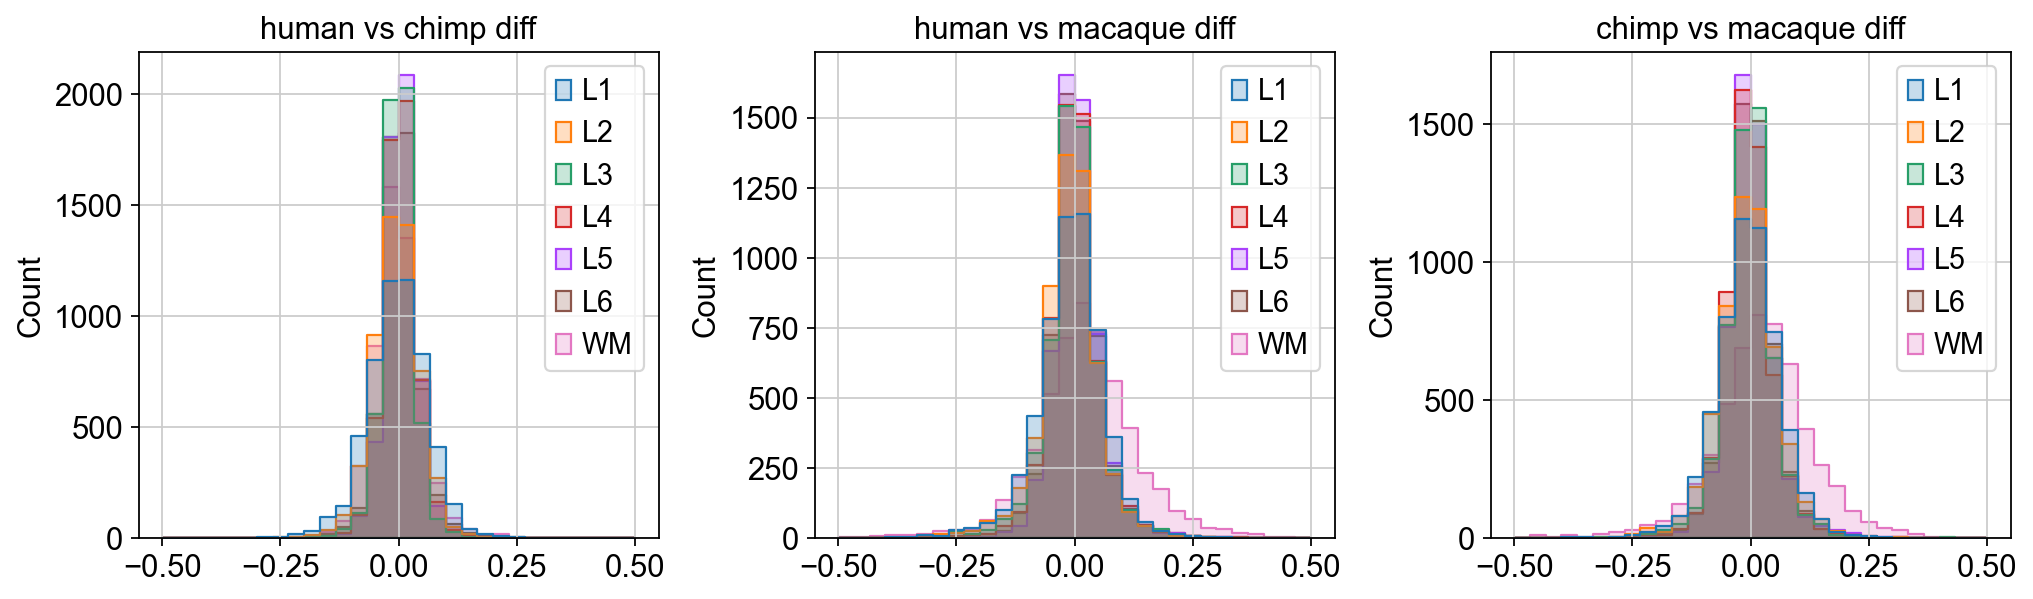

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), gridspec_kw={'wspace': 0.3})

sns.histplot(human_chimp_diff, bins=30, element="step", ax=ax[0], binrange=[-0.5, 0.5])
ax[0].set_title('human vs chimp diff')

sns.histplot(human_macaque_diff, bins=30, element="step", ax=ax[1], binrange=[-0.5, 0.5])
ax[1].set_title('human vs macaque diff')

sns.histplot(chimp_macaque_diff, bins=30, element="step", ax=ax[2], binrange=[-0.5, 0.5])
ax[2].set_title('chimp vs macaque diff')

Text(0, 0.5, 'Number of genes')

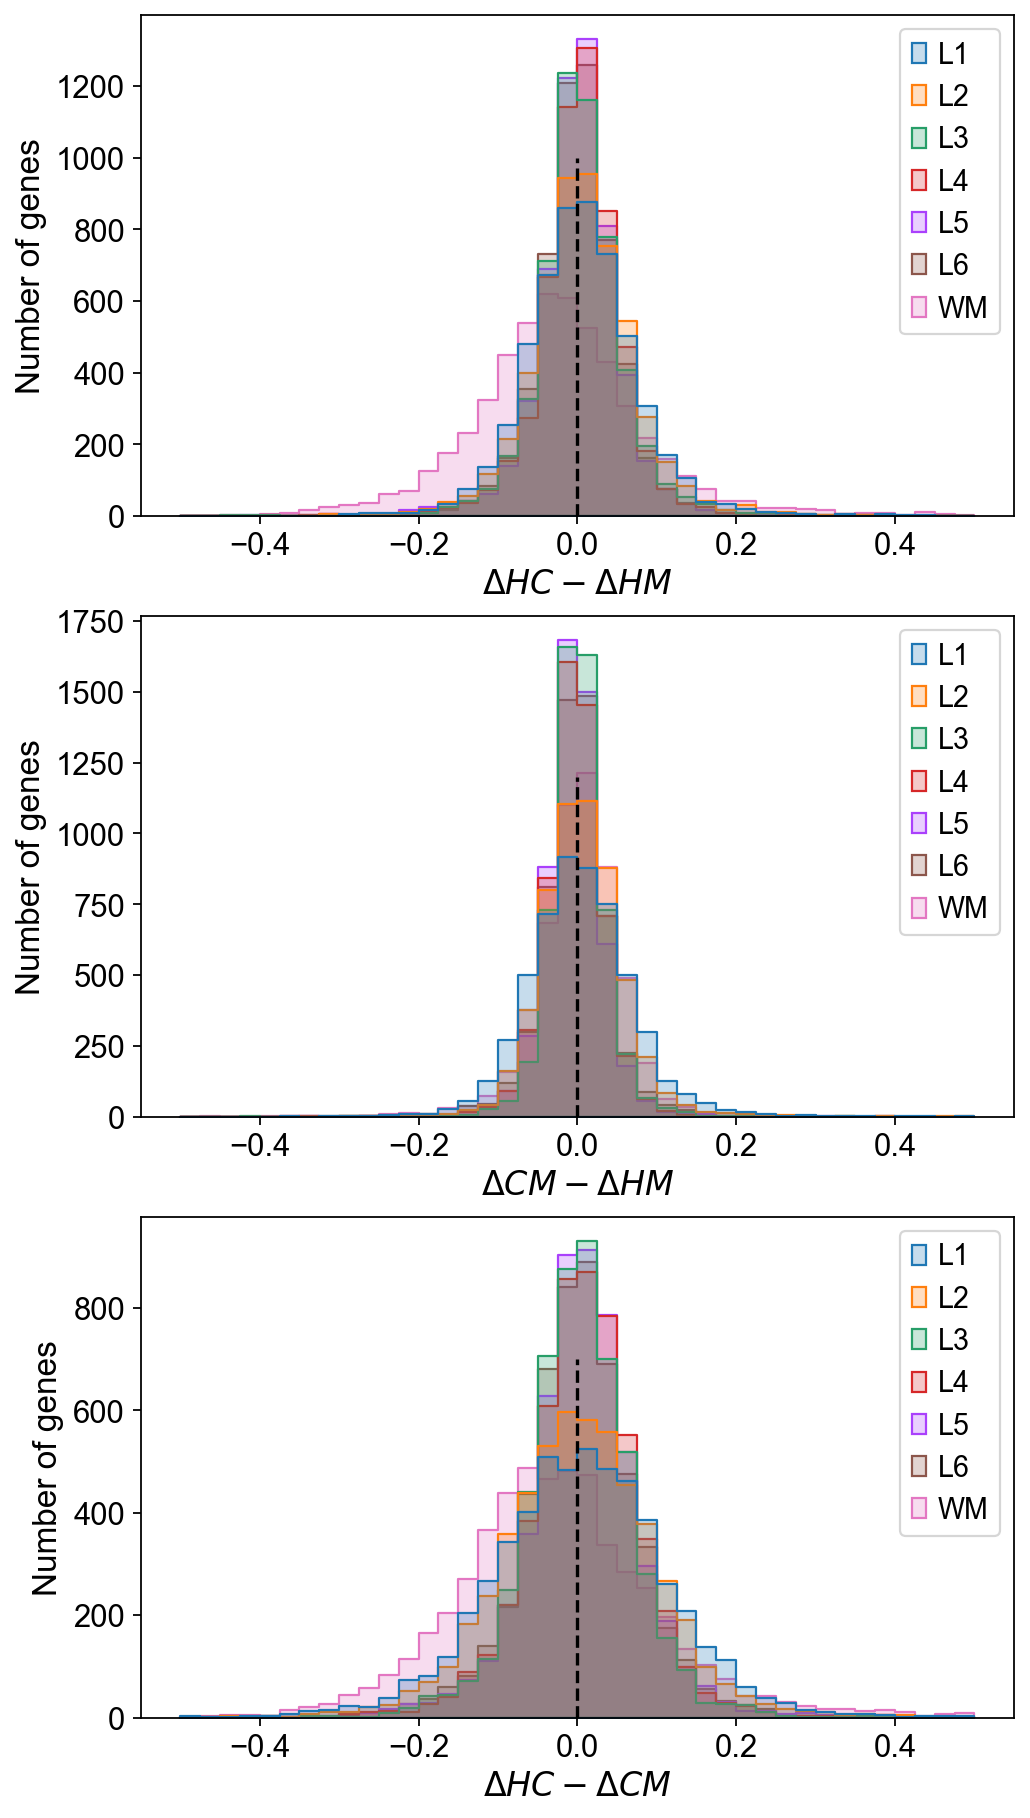

In [21]:
fig, ax = plt.subplots(3, 1, figsize=(7, 14))

data_to_plot = human_chimp_diff - human_macaque_diff
sns.histplot(data_to_plot, element="step", binrange=[-0.5, 0.5], bins=40, ax=ax[0])
ax[0].vlines(0, ymin=0, ymax=1000, colors='black', linestyles='dashed')
ax[0].grid(False)
ax[0].set_xlabel('$\Delta HC - \Delta HM$', fontsize=15)
ax[0].set_ylabel('Number of genes', fontsize=15)

data_to_plot = chimp_macaque_diff - human_macaque_diff
sns.histplot(data_to_plot, element="step", binrange=[-0.5, 0.5], bins=40, ax=ax[1])
ax[1].vlines(0, ymin=0, ymax=1200, colors='black', linestyles='dashed')
ax[1].grid(False)
ax[1].set_xlabel('$\Delta CM - \Delta HM$', fontsize=15)
ax[1].set_ylabel('Number of genes', fontsize=15)

data_to_plot = human_chimp_diff - chimp_macaque_diff
sns.histplot(data_to_plot, element="step", binrange=[-0.5, 0.5], bins=40, ax=ax[2])
ax[2].vlines(0, ymin=0, ymax=700, colors='black', linestyles='dashed')
ax[2].grid(False)
ax[2].set_xlabel('$\Delta HC - \Delta CM$', fontsize=15)
ax[2].set_ylabel('Number of genes', fontsize=15)

## Let's explore

In [22]:
#human_chimp_diff, human_macaque_diff, chimp_macaque_diff

In [23]:
hc_l1 = human_chimp_diff.abs().sum(axis=1)
hm_l1 = human_macaque_diff.abs().sum(axis=1)
cm_l1 = chimp_macaque_diff.abs().sum(axis=1)

(0.0, 4.0)

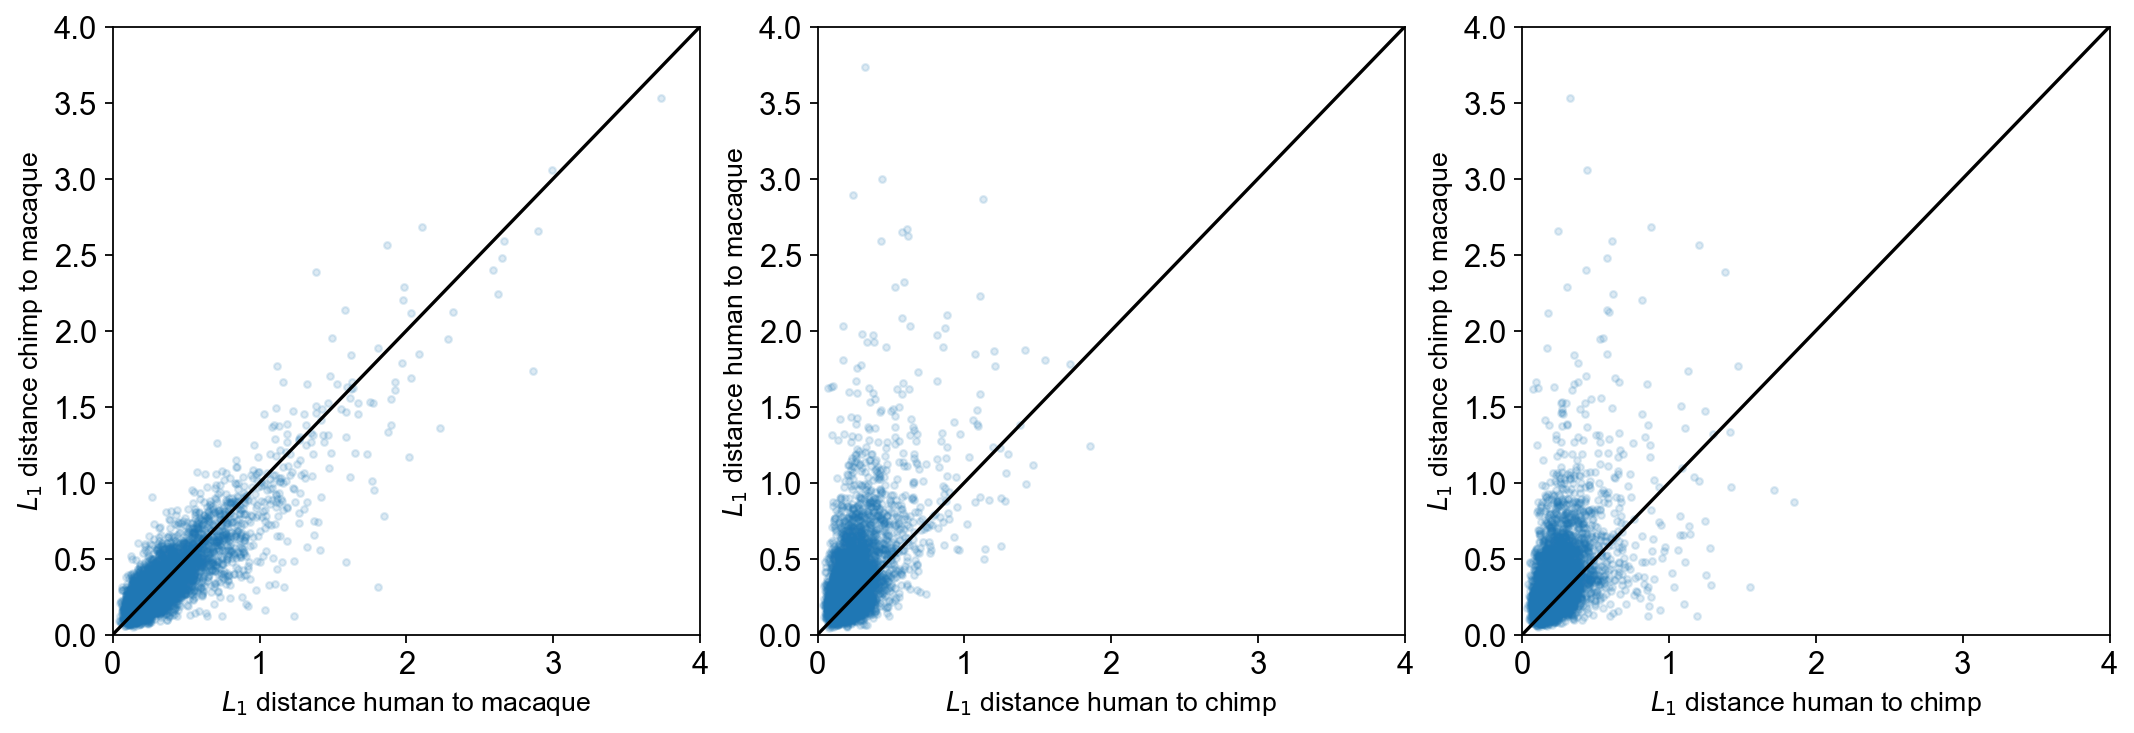

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(hm_l1, cm_l1, '.', alpha=0.15)
ax[0].plot([0, 9], [0, 9], 'black')
#ax[0].set_title('Z-score-like normalization')
ax[0].set_xlabel('$L_1$ distance human to macaque', fontsize=12)
ax[0].set_ylabel('$L_1$ distance chimp to macaque', fontsize=12)
ax[0].grid(False)
ax[0].set_xlim(0, 4)
ax[0].set_ylim(0, 4)

ax[1].plot(hc_l1, hm_l1, '.', alpha=0.15)
ax[1].plot([0, 9], [0, 9], 'black')
#ax[1].set_title('Z-score-like normalization')
ax[1].set_xlabel('$L_1$ distance human to chimp', fontsize=12)
ax[1].set_ylabel('$L_1$ distance human to macaque', fontsize=12)
ax[1].grid(False)
ax[1].set_xlim(0, 4)
ax[1].set_ylim(0, 4)

ax[2].plot(hc_l1, cm_l1, '.', alpha=0.15)
ax[2].plot([0, 9], [0, 9], 'black')
#ax[2].set_title('Z-score-like normalization')
ax[2].set_xlabel('$L_1$ distance human to chimp', fontsize=12)
ax[2].set_ylabel('$L_1$ distance chimp to macaque', fontsize=12)
ax[2].grid(False)
ax[2].set_xlim(0, 4)
ax[2].set_ylim(0, 4)

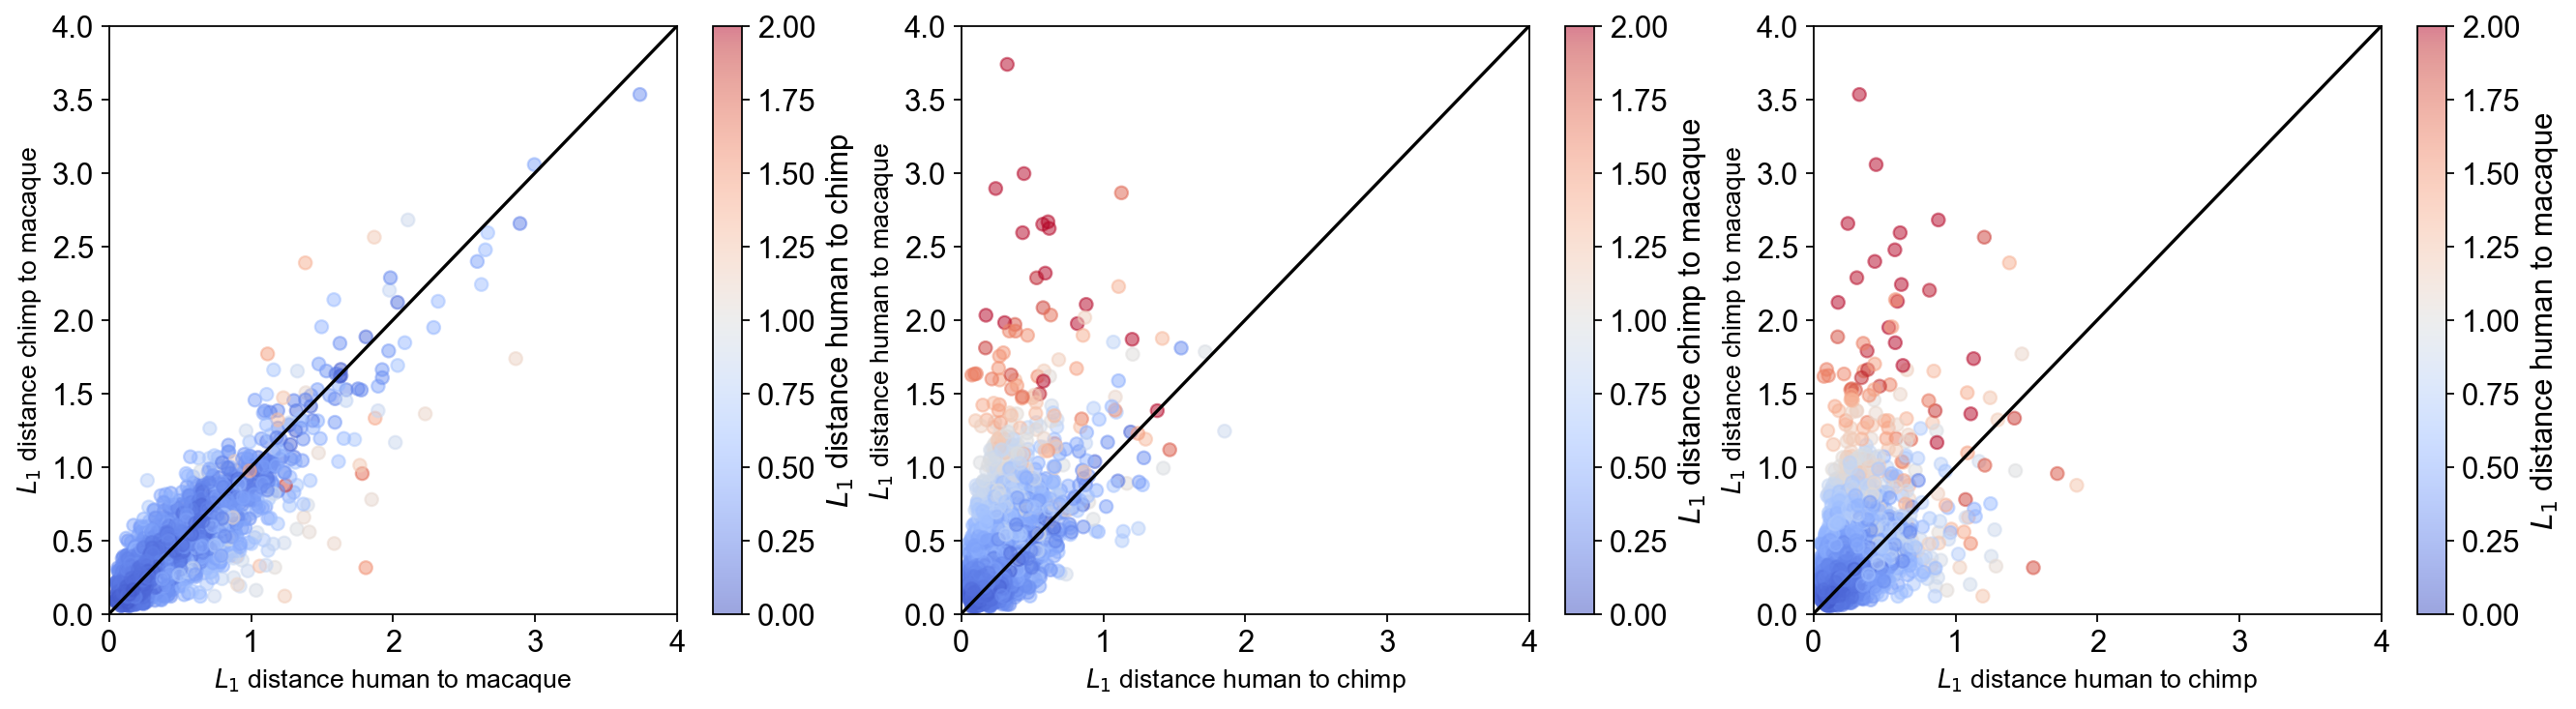

In [25]:
import matplotlib as mpl
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=0, vmax=2, clip=True)
marker = 'o'
alpha = 0.5

im = ax[0].scatter(hm_l1, cm_l1, c=hc_l1, alpha=alpha, cmap=cmap, norm=norm, marker=marker)
ax[0].plot([0, 9], [0, 9], 'black')
#ax[0].set_title('Z-score-like normalization')
ax[0].set_xlabel('$L_1$ distance human to macaque', fontsize=12)
ax[0].set_ylabel('$L_1$ distance chimp to macaque', fontsize=12)
ax[0].grid(False)
ax[0].set_xlim(0, 4)
ax[0].set_ylim(0, 4)
fig.colorbar(im, ax=ax[0], label="$L_1$ distance human to chimp")

im = ax[1].scatter(hc_l1, hm_l1, c=cm_l1, alpha=alpha, cmap=cmap, norm=norm, marker=marker)
ax[1].plot([0, 9], [0, 9], 'black')
#ax[1].set_title('Z-score-like normalization')
ax[1].set_xlabel('$L_1$ distance human to chimp', fontsize=12)
ax[1].set_ylabel('$L_1$ distance human to macaque', fontsize=12)
ax[1].grid(False)
ax[1].set_xlim(0, 4)
ax[1].set_ylim(0, 4)
fig.colorbar(im, ax=ax[1], label="$L_1$ distance chimp to macaque")

im = ax[2].scatter(hc_l1, cm_l1, c=hm_l1, alpha=alpha, cmap=cmap, norm=norm, marker=marker)
ax[2].plot([0, 9], [0, 9], 'black')
#ax[2].set_title('Z-score-like normalization')
ax[2].set_xlabel('$L_1$ distance human to chimp', fontsize=12)
ax[2].set_ylabel('$L_1$ distance chimp to macaque', fontsize=12)
ax[2].grid(False)
ax[2].set_xlim(0, 4)
ax[2].set_ylim(0, 4)
fig.colorbar(im, ax=ax[2], label="$L_1$ distance human to macaque")
plt.show()

## Find genes with conserved profiles

In [26]:
#hc_l1, hm_l1, cm_l1

In [27]:
hc_l1.name = 'human-chimp'
hm_l1.name = 'human-macaque'
cm_l1.name = 'chimp-macaque'

In [28]:
quantile = 0.3
quant_value = hc_l1.quantile(quantile)
quant_value

0.16533183604478835

Let's check the distribution of distances between profiles

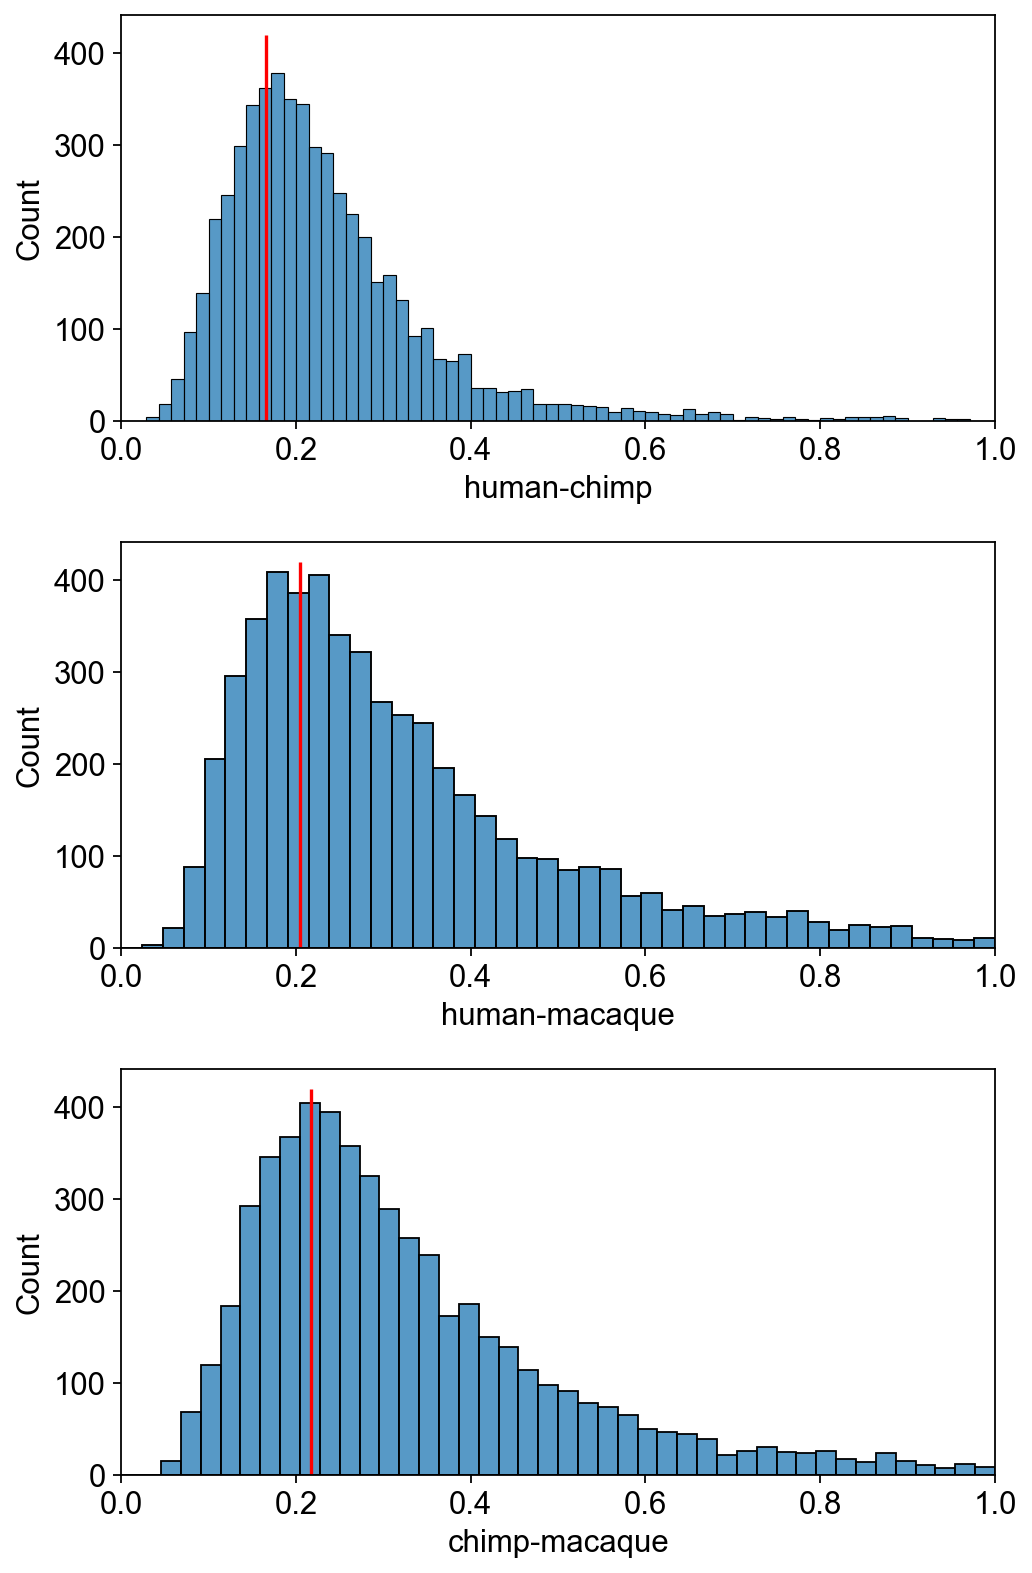

In [29]:
fig, axes = plt.subplots(3, 1, figsize=(7, 12), gridspec_kw={'hspace': 0.3})

for ax, sp_ldist in zip(axes, [hc_l1, hm_l1, cm_l1]):
    quantile = 0.3
    quant_value = sp_ldist.quantile(quantile)
    sns.histplot(sp_ldist, ax=ax, binrange=[0, 1])
    ax.vlines(quant_value, ymin=0, ymax=420,colors='red')
    ax.set_xlim(0, 1)
    ax.grid(False)

Let's check the distribution of L1 norms of gene profiles

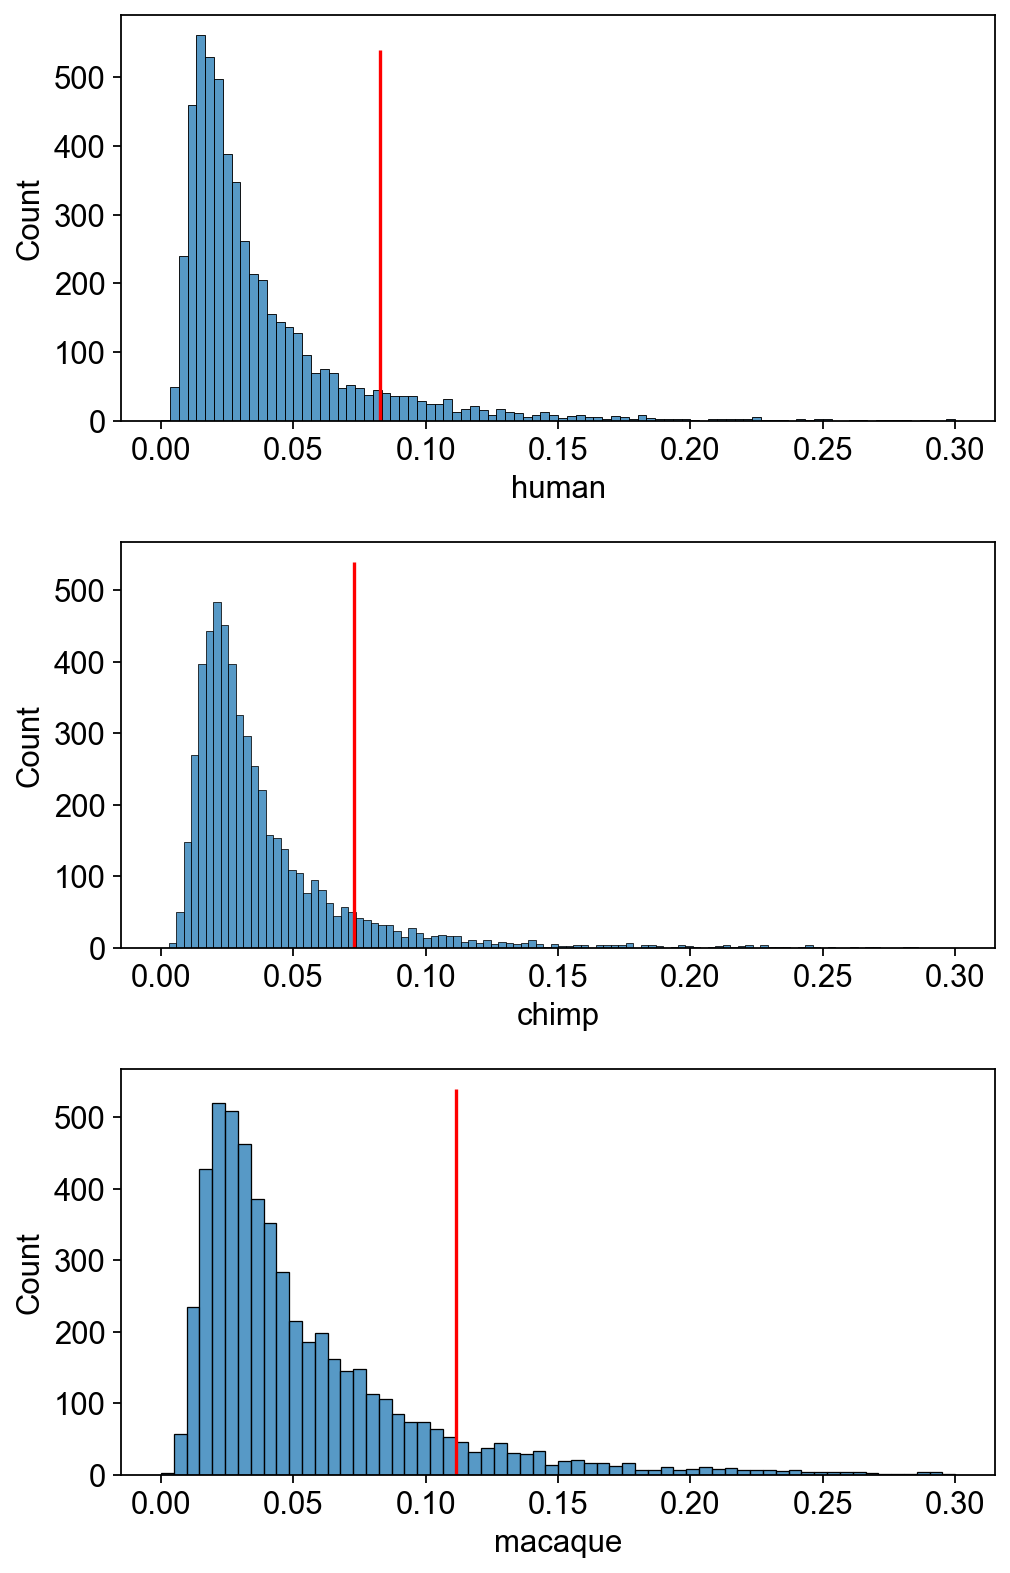

In [30]:
fig, axes = plt.subplots(3, 1, figsize=(7, 12), gridspec_kw={'hspace': 0.3})

for ax, specie in zip(axes, ['human', 'chimp', 'macaque']):
    quantile = 0.9
    l1_norm = mean_norm_expr_dict[specie].abs().mean(axis=1)
    quant_value = l1_norm.quantile(quantile)
    sns.histplot(l1_norm, ax=ax, binrange=[0, 0.3])
    ax.vlines(quant_value, ymin=0, ymax=540,colors='red')
    ax.set_xlabel(specie)
    #ax.set_xlim(0, 1)
    ax.grid(False)

In [31]:
[hc_l1, hm_l1, cm_l1]

[AACS       0.240027
 AAGAB      0.131489
 AAK1       0.286248
 AAMP       0.134176
 AAR2       0.134535
              ...   
 ZRANB2     0.191756
 ZSCAN18    0.157306
 ZSCAN21    0.090758
 ZUP1       0.130766
 ZZZ3       0.072470
 Name: human-chimp, Length: 5390, dtype: float32,
 AACS       0.541052
 AAGAB      0.242011
 AAK1       0.333881
 AAMP       0.135259
 AAR2       0.252478
              ...   
 ZRANB2     0.277799
 ZSCAN18    0.183114
 ZSCAN21    0.144699
 ZUP1       0.097204
 ZZZ3       0.169566
 Name: human-macaque, Length: 5390, dtype: float32,
 AACS       0.498506
 AAGAB      0.193055
 AAK1       0.147427
 AAMP       0.131759
 AAR2       0.213013
              ...   
 ZRANB2     0.245356
 ZSCAN18    0.214161
 ZSCAN21    0.132217
 ZUP1       0.141312
 ZZZ3       0.163429
 Name: chimp-macaque, Length: 5390, dtype: float32]

Let's pick up the genes with similar profiles

In [32]:
max_dist = 0.2
condition1 = ((hc_l1 < max_dist) & (hm_l1 < max_dist) & (cm_l1 < max_dist))
condition1.sum()

708

In [33]:
l1_norm = mean_norm_expr_dict['human'].abs().mean(axis=1)
condition2 = (l1_norm > 0.05)
condition2.sum()

1200

In [34]:
(condition1 & condition2).sum()

16

In [35]:
conserved_genes = condition1[(condition1 & condition2)].index
conserved_genes

Index(['ACVR2A', 'ANAPC16', 'BMP7', 'FAM120A', 'FAM167A', 'NIPBL', 'NSRP1',
       'PAFAH1B1', 'PTK7', 'RAB34', 'RBPJ', 'SERPINB6', 'SPART', 'TYROBP',
       'VDAC3', 'VTA1'],
      dtype='object')

## Let's plot these profiles

In [36]:
from scipy.interpolate import UnivariateSpline

In [37]:
df_cont = df.copy()
df_cont['layer'] = adata_pb_norm.obs.layer.map(dict(zip(sorted(adata_pb_norm.obs.layer.unique()), range(1, 8)))).astype(int)
df_cont['condition'] = adata_pb_norm.obs.condition

In [38]:
grid = np.linspace(1, 7, 400)
conditions = ['human', 'chimp', 'macaque']
cond_colors = ['tab:red', 'tab:orange', 'tab:green']

In [39]:
from scipy.interpolate import UnivariateSpline

array = np.zeros((grid.size, conserved_genes.size))
df_list = []

for specie in conditions:
    for i, gene in enumerate(conserved_genes.to_list()):
        #fit spline
        subs_index = df_cont[df_cont.condition == specie].index
        targ_dataset = df_cont.loc[subs_index].copy().sort_values(by='layer')
        x = targ_dataset['layer'].values
        y = targ_dataset[gene].values
        spl = UnivariateSpline(x, y, k=3)
        array[:, i] = spl(grid)
    df_specie = pd.DataFrame(array, columns=conserved_genes)
    df_specie['condition'] = specie
    df_list.append(df_specie.copy())
df_spline = pd.concat(df_list)

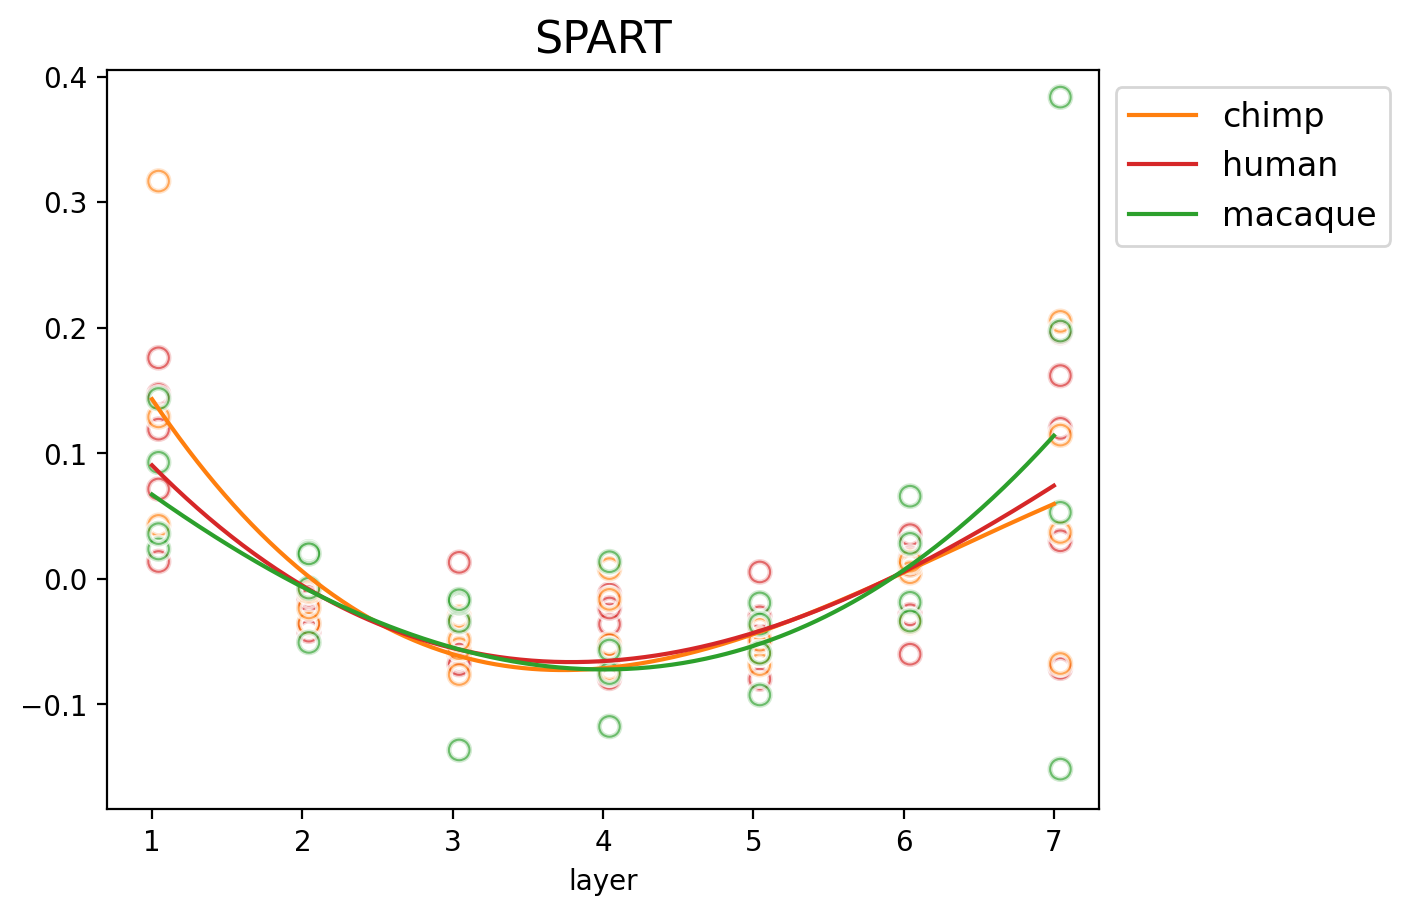

In [40]:
mpl.rcdefaults()
fig, ax = plt.subplots()

gene = 'SPART'
df_cluster_spline = df_spline[[gene, 'condition']].copy()
df_cluster_spline = df_cluster_spline.pivot(columns='condition', values=gene)
df_cluster_spline.index = grid
df_cluster_spline.plot.line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax)

df_cluster_values = df_cont[[gene, 'condition', 'layer']].copy()
palette = {'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}
sns.scatterplot(df_cont, x='layer', y=gene, hue='condition', palette=palette, ax=ax, legend=False, alpha=0.7, marker="$\circ$", s=200)
ax.set_ylabel('')
ax.set_title(gene, fontsize=16)
ax.legend(fontsize=10, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":12})

0it [00:00, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: 'results/figures/conserved_genes_profiles.pdf'

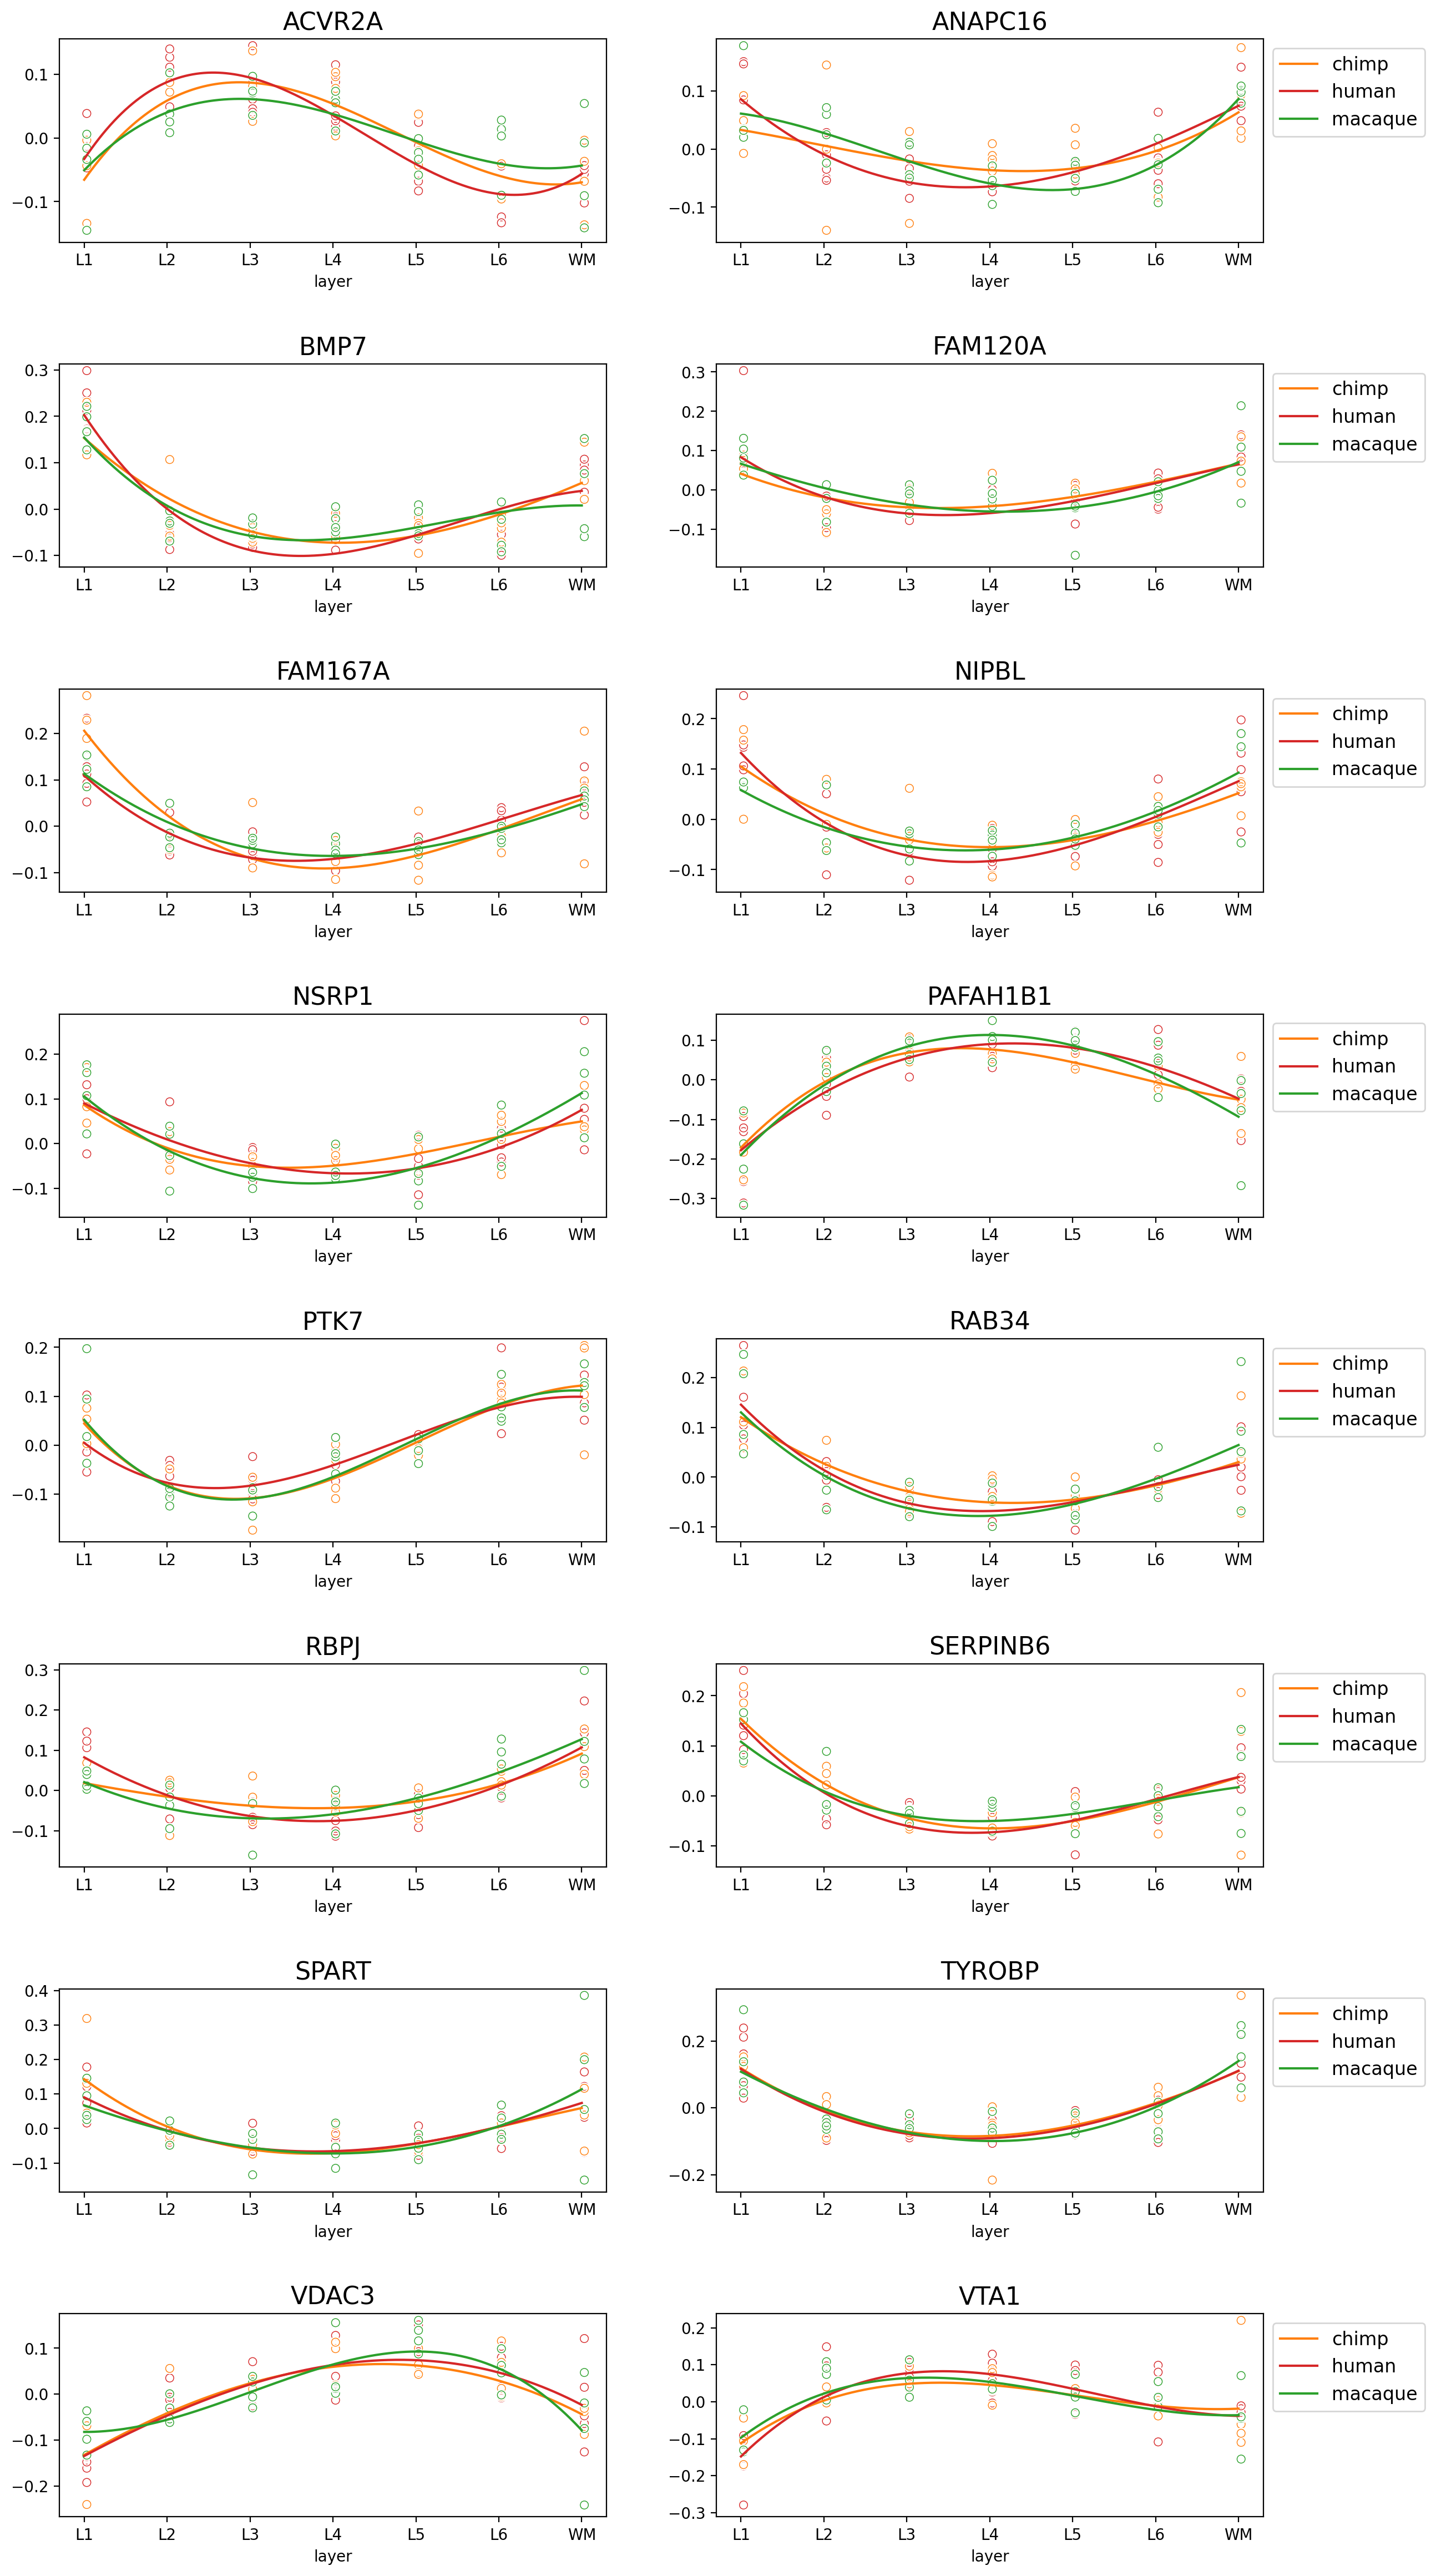

In [41]:
from tqdm.notebook import tqdm
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

mpl.rcdefaults()

genes = conserved_genes
fig, axes = plt.subplots((len(genes) + 1) // 2, 2,  figsize=(14, 3.5 * (len(genes) + 1) // 2), gridspec_kw={'hspace': 0.6})

for i, (gene, ax) in tqdm(enumerate(zip(genes, axes.flatten()))):
    df_cluster_spline = df_spline[[gene, 'condition']].copy()
    df_cluster_spline = df_cluster_spline.pivot(columns='condition', values=gene)
    df_cluster_spline.index = grid
    df_cluster_spline.plot.line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax)
    
    df_cluster_values = df_cont[[gene, 'condition', 'layer']].copy()
    palette = {'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}
    sns.scatterplot(df_cont, x='layer', y=gene, hue='condition', palette=palette, ax=ax, legend=False, alpha=1, marker="$\circ$", s=100)
    ax.set_ylabel('')
    
    
    ax.legend(fontsize=10, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":12})
    ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(1, 8)))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))

    if i % 2 == 0:
        ax.get_legend().remove()

    ax.set_title(f'{gene}', fontsize=16)
    ax.grid(False)
    #ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')
plt.savefig(f'results/figures/conserved_genes_profiles.pdf')

In [ ]:
df_pb = pd.DataFrame(adata_pb.X, index=adata_pb.obs_names, columns=adata_pb.var_names)
df_pb = df_pb.loc[sample_order['all']]

In [ ]:
df_cont_pb = df_pb.copy()
df_cont_pb['layer'] = adata_pb.obs.layer.map(dict(zip(sorted(adata_pb.obs.layer.unique()), range(1, 8)))).astype(int)
df_cont_pb['condition'] = adata_pb.obs.condition

In [ ]:
from scipy.interpolate import UnivariateSpline

array = np.zeros((grid.size, conserved_genes.size))
df_list = []

for specie in conditions:
    for i, gene in enumerate(conserved_genes.to_list()):
        #fit spline
        subs_index = df_cont_pb[df_cont_pb.condition == specie].index
        targ_dataset = df_cont_pb.loc[subs_index].copy().sort_values(by='layer')
        x = targ_dataset['layer'].values
        y = targ_dataset[gene].values
        spl = UnivariateSpline(x, y, k=3)
        array[:, i] = spl(grid)
    df_specie = pd.DataFrame(array, columns=conserved_genes)
    df_specie['condition'] = specie
    df_list.append(df_specie.copy())
df_spline_pb = pd.concat(df_list)

In [ ]:
mpl.rcdefaults()

genes = conserved_genes
fig, axes = plt.subplots((len(genes)), 2,  figsize=(14, 3.5 * (len(genes))), gridspec_kw={'hspace': 0.6})

for i, gene in tqdm(enumerate(genes)):
    df_cluster_spline = df_spline[[gene, 'condition']].copy()
    df_cluster_spline = df_cluster_spline.pivot(columns='condition', values=gene)
    df_cluster_spline.index = grid
    df_cluster_spline.plot.line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=axes[i, 0])
    
    df_cluster_values = df_cont[[gene, 'condition', 'layer']].copy()
    palette = {'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}
    sns.scatterplot(df_cont, x='layer', y=gene, hue='condition', palette=palette, ax=axes[i, 0], legend=False, alpha=1, marker="$\circ$", s=100)
    axes[i, 0].set_ylabel('')
    
    
    axes[i, 0].legend(fontsize=10, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":12})
    axes[i, 0].set_title(f'{gene}', fontsize=16)
    axes[i, 0].xaxis.set_major_locator(ticker.FixedLocator(np.arange(1, 8)))
    axes[i, 0].xaxis.set_major_formatter(ticker.FixedFormatter(layers))
    axes[i, 0].get_legend().remove()


    df_cluster_spline = df_spline_pb[[gene, 'condition']].copy()
    df_cluster_spline = df_cluster_spline.pivot(columns='condition', values=gene)
    df_cluster_spline.index = grid
    df_cluster_spline.plot.line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=axes[i, 1])
    
    df_cluster_values = df_cont_pb[[gene, 'condition', 'layer']].copy()
    palette = {'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}
    sns.scatterplot(df_cont_pb, x='layer', y=gene, hue='condition', palette=palette, ax=axes[i, 1], legend=False, alpha=1, marker="$\circ$", s=100)
    axes[i, 1].set_ylabel('')
    
    
    axes[i, 1].legend(fontsize=10, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":10})
    axes[i, 1].set_title(f'{gene} Log(CP10K)', fontsize=16)
    axes[i, 1].xaxis.set_major_locator(ticker.FixedLocator(np.arange(1, 8)))
    axes[i, 1].xaxis.set_major_formatter(ticker.FixedFormatter(layers))
        
        #axes[i, 1].hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')
plt.savefig(f'results/clusters{0.01}/conserved_genes.pdf')

# Slides

In [ ]:
import squidpy as sq

## All spots

In [ ]:
adata_human = sc.read_h5ad('../../data/raw_adata/human.h5ad')
adata_human.obs_names_make_unique()
adata_human = adata_human[adata_human.obs.label != 'Empty spots']
adata_human

In [ ]:
nice_conserved_genes = ['VTA1', 'VDAC3', 'SPART', 'PAFAH1B1', 'ANAPC16']

In [ ]:
sc.pp.normalize_total(adata_human, target_sum=1e4)
sc.pp.log1p(adata_human)

In [ ]:
import matplotlib
matplotlib.rcdefaults()

In [ ]:
matplotlib.cm.viridis

In [ ]:
 matplotlib.cm.Spectral_r

In [ ]:
adata_human.uns['spatial'].keys()

In [ ]:
matplotlib.rcdefaults()
cmap = matplotlib.cm.viridis
norm = matplotlib.colors.Normalize(vmin=0, vmax=3, clip=True)
sq.pl.spatial_scatter(adata_human,
                      color=['VTA1', 'VDAC3', 'ANAPC16', 'label'],
                      library_id=['human_j3', 'human_j4', 'human_j6'],
                      library_key='sample_id', ncols=4, img=True,
                      size=1.3, wspace=0.01, cmap=cmap, norm=norm, dpi=120,
                      save=f'human_conserved_viridis.pdf')

In [ ]:
matplotlib.rcdefaults()
cmap = matplotlib.cm.Spectral_r
norm = matplotlib.colors.Normalize(vmin=0, vmax=3.5, clip=True)
sq.pl.spatial_scatter(adata_human,
                      color=['VTA1', 'VDAC3', 'ANAPC16', 'label'],
                      library_id=['human_j3', 'human_j4', 'human_j6'],
                      library_key='sample_id', ncols=4, img=True, size=1.3,
                      wspace=0.01, cmap=cmap, norm=norm, dpi=120,
                      save=f'human_conserved_spectral.pdf')

In [ ]:
#fig, axes = plt.subplots(5, 1, figsize=(6, 15), gridspec_kw={'hspace': 0.5})
matplotlib.rcdefaults()
cmap = matplotlib.cm.viridis
norm = matplotlib.colors.Normalize(vmin=0, vmax=3, clip=True)

gene = 'VDAC3'
sq.pl.spatial_scatter(adata_human,
                      color=[gene, 'label'], library_id=['human_j4', 'human_j6'],
                      library_key='sample_id', ncols=2, img=True, size=1.3, cmap=cmap)

In [ ]:
adata_chimp = sc.read_h5ad('../../data/raw_adata/chimp.h5ad')
adata_chimp.obs_names_make_unique()
adata_chimp = adata_chimp[adata_chimp.obs.label != 'Empty spots']
adata_chimp

In [ ]:
sc.pp.normalize_total(adata_chimp, target_sum=1e4)
sc.pp.log1p(adata_chimp)

In [ ]:
adata_chimp.uns['spatial'].keys()

In [ ]:
matplotlib.rcdefaults()
cmap = matplotlib.cm.viridis
norm = matplotlib.colors.Normalize(vmin=0, vmax=2.7, clip=True)
sq.pl.spatial_scatter(adata_chimp,
                      color=['VTA1', 'VDAC3', 'ANAPC16', 'label'],
                      library_id=['chimp_11454', 'chimp_13309'],
                      library_key='sample_id', ncols=4, img=True, size=1.3,
                      wspace=0.01, cmap=cmap, norm=norm, dpi=120,
                      save=f'chimp_conserved_viridis.pdf')

In [ ]:
matplotlib.rcdefaults()
cmap = matplotlib.cm.Spectral_r
norm = matplotlib.colors.Normalize(vmin=0, vmax=4, clip=True)
sq.pl.spatial_scatter(adata_chimp,
                      color=['VTA1', 'VDAC3', 'ANAPC16', 'label'],
                      library_id=['chimp_13309'],
                      library_key='sample_id', ncols=4, img=True, size=1.3,
                      wspace=0.01, cmap=cmap, norm=norm, dpi=120,
                      save=f'chimp_conserved_spectral.pdf')

In [ ]:
cmap = matplotlib.cm.viridis
norm = matplotlib.colors.Normalize(vmin=0.5, vmax=2.5, clip=True)

gene = 'VDAC3'
sq.pl.spatial_scatter(adata_chimp,
                      color=[gene, 'label'],
                      library_key='sample_id', ncols=2, img=True, size=1.3)

In [ ]:
adata_macaque = sc.read_h5ad('../../data/raw_adata/macaque.h5ad')
adata_macaque.obs_names_make_unique()
adata_macaque = adata_macaque[adata_macaque.obs.label != 'Empty spots']
adata_macaque

In [ ]:
sc.pp.normalize_total(adata_macaque, target_sum=1e4)
sc.pp.log1p(adata_macaque)

In [ ]:
adata_macaque.uns['spatial'].keys()

In [ ]:
matplotlib.rcdefaults()
cmap = matplotlib.cm.viridis
norm = matplotlib.colors.Normalize(vmin=0, vmax=2.5, clip=True)
sq.pl.spatial_scatter(adata_macaque,
                      color=['VTA1', 'VDAC3', 'ANAPC16', 'label'],
                      library_id=['macaque_0701'],
                      library_key='sample_id', ncols=4, img=True, size=1.3,
                      wspace=0.01, cmap=cmap, norm=norm, dpi=120,
                      save=f'macaque_conserved_viridis.pdf')

In [ ]:
matplotlib.rcdefaults()
cmap = matplotlib.cm.Spectral_r
norm = matplotlib.colors.Normalize(vmin=0, vmax=4.3, clip=True)
sq.pl.spatial_scatter(adata_macaque,
                      color=['VTA1', 'VDAC3', 'ANAPC16', 'label'],
                      library_id=['macaque_0701'],
                      library_key='sample_id', ncols=4, img=True, size=1.3,
                      wspace=0.01, cmap=cmap, norm=norm, dpi=120,
                      save=f'macaque_conserved_spectral.pdf')

In [ ]:
import glob
from pypdf import PdfMerger

pdf_files = glob.glob(f'figures/*conserved_viridis.pdf')
merger = PdfMerger()
for pdf in pdf_files:
    merger.append(pdf)
merger.write(f"figures/conserved_viridis.pdf")
merger.close()

pdf_files = glob.glob(f'figures/*conserved_spectral.pdf')
merger = PdfMerger()
for pdf in pdf_files:
    merger.append(pdf)
merger.write(f"figures/conserved_spectral.pdf")
merger.close()

pdf_files = glob.glob(f'figures/conserved_*.pdf')
merger = PdfMerger()
for pdf in pdf_files:
    merger.append(pdf)
merger.write(f"figures/conserved.pdf")
merger.close()

In [ ]:
# import glob
# from pypdf import PdfMerger

# for gene in pretty_genes:
#     pdf_files = glob.glob(f'figures/*{gene}.pdf')
#     merger = PdfMerger()
#     for pdf in pdf_files:
#         merger.append(pdf)
#     merger.write(f"figures/{gene}_all.pdf")
#     merger.close()

In [ ]:
# pdf_files = glob.glob(f'figures/*all.pdf')
# merger = PdfMerger()
# for pdf in pdf_files:
#     merger.append(pdf)
# merger.write(f"figures/pretty_genes_all.pdf")
# merger.close()